---
# Load data
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
AMD_data = np.load("AMD.npy")
INTC_data = np.load("INTC.npy")
Micron_data = np.load("Micron.npy")

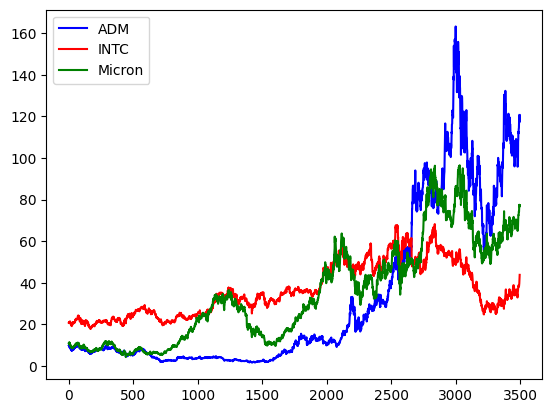

In [3]:
plt.plot(AMD_data, "b-")
plt.plot(INTC_data, "r-")
plt.plot(Micron_data, "g-")
plt.legend(["ADM", "INTC", "Micron"])
plt.show()

In [4]:
AMD_data.shape, INTC_data.shape, Micron_data.shape

((3495, 1), (3495, 1), (3495, 1))

---
# Data processing
---

In [5]:
data = np.hstack([AMD_data, INTC_data, Micron_data])
data.shape

(3495, 3)

In [6]:
max_data = np.max(data, axis = 0)
data = data/max_data

In [7]:
data_train = data[:3301]
data_test = data[3301:]

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps) :
    X, y = list(), list()
    for i in range(len(sequences)) :
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond dataset
        if end_ix > len(sequences) - 1 :
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
# choose a number of time steps
n_steps = 20

# convert into input/output
X_train, y_train = split_sequences(data_train, n_steps)
X_test, y_test = split_sequences(data_test, n_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3281, 20, 3) (3281, 3)
(174, 20, 3) (174, 3)


---
# Deep learning model
---

In [11]:
from keras import Input
from keras.layers import LSTM, Dense, Bidirectional, GRU
from keras.models import Model
from keras import optimizers
from keras.utils import plot_model

In [43]:
learning_rate = 0.0004
N1 = 100
N2 = 100

# define model
x0 = Input(shape = (X_train.shape[1:]))
x1 = Bidirectional(GRU(N1, activation = "tanh", return_sequences = True))(x0)
x2 = Bidirectional(GRU(N2, activation = "relu"))(x1)
output = Dense(3)(x2)

model = Model(inputs = x0, outputs = output)
model.compile(optimizer = optimizers.Adam(learning_rate = learning_rate), loss = "mse")

plot_model(model, "model.png", show_shapes = True)

# model fitting
history = model.fit(X_train, y_train, epochs = 100, verbose = 1)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0483
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.4030e-04
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3790e-04
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4619e-04
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0158e-04
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.5828e-04
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.2340e-04
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0341e-04
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0552e-04
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7113e-04
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3908e-04
Epoch 12/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3929e-04
Epoch 13/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.0602e-04
Epoch 14/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/s

# Plot losses

import pandas as pd

pd.DataFrame(history.history).plot(
    figsize = (8, 5), xlim = [0, len(history.epoch) - 1], grid = True, xlabel = "Epoch", style = ["r--", "b--."]
)
plt.show()

In [44]:
y_pred2 = model.predict(X_test)*max_data
y_true2 = y_test*max_data

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [ ]:
mse = 0
for i in range(len(y_pred2)) :
    mse += (np.linalg.norm((y_pred2[i, :] - y_true2[i, :])))**2
print(mse/174)

13.405757414498206


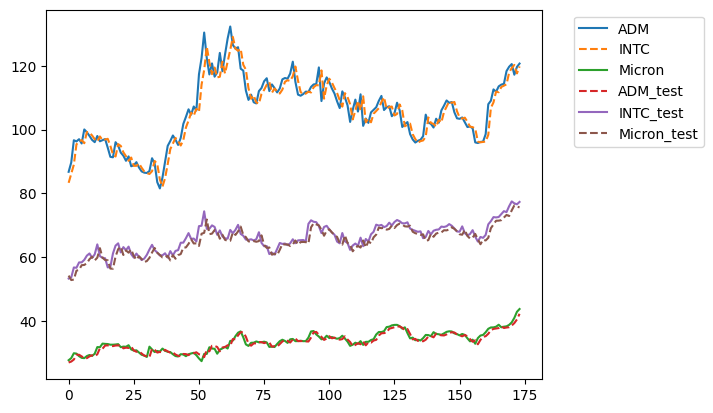

In [48]:
for i in range (3) :
    plt.plot(y_true2[:, i], "-")
    plt.plot(y_pred2[:, i], "--")
plt.legend(["ADM", "INTC", "Micron", "ADM_test", "INTC_test", "Micron_test"],
           bbox_to_anchor = (1.05, 1))
plt.show()